In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/milandataset/milan-dataset1.csv


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [3]:
import os

# لیست کردن فایل‌ها و مسیرهای موجود در /kaggle/input/
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/milandataset/milan-dataset1.csv


In [4]:
import pandas as pd

# مسیر فایل CSV
dataset_path = '/kaggle/input/milandataset/milan-dataset1.csv'

# بارگذاری داده‌ها
data = pd.read_csv(dataset_path)

# نمایش بخشی از داده‌ها برای بررسی
print(data.head())

   10/16/2009  0:01:04  59  M017   ON Unnamed: 5 Unnamed: 6
0  10/16/2009  0:01:06  46  M009   ON        NaN        NaN
1  10/16/2009  0:01:07  64  M017  OFF        NaN        NaN
2  10/16/2009  0:01:08  81  M019   ON        NaN        NaN
3  10/16/2009  0:01:09  28  M009  OFF        NaN        NaN
4  10/16/2009  0:01:13  51  M019  OFF        NaN        NaN


In [5]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
#from google.colab import drive

#drive.mount('/content/drive')

# بارگذاری داده‌ها
#dataset_path = '/content/drive/MyDrive/milan-dataset1.csv'

# بارگذاری داده‌ها
data = pd.read_csv(dataset_path, delimiter=',', header=None, names=['Date', 'Time', 'Interval', 'Sensor ID', 'State', 'Activity Label', 'Start/End'])

# اصلاح فرمت ستون "Date"
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y', errors='coerce')

# پیش‌پردازش ستون 'Time' و تبدیل به ثانیه
def preprocess_time_to_seconds(value):
    try:
        time_parts = value.split(':')
        minutes = int(time_parts[0])
        seconds = float(time_parts[1])
        total_seconds = minutes * 60 + seconds
        return total_seconds
    except (ValueError, IndexError):
        return np.nan  # اگر خطا بود، مقدار نان برمی‌گرداند

# تبدیل ستون 'Time' به ثانیه
data['Time_in_Seconds'] = data['Time'].apply(preprocess_time_to_seconds)

# پیش‌پردازش ستون 'State'
def preprocess_state(value):
    if value in ['ON', 'OPEN']:
        return 1.0
    elif value in ['OFF', 'CLOSE']:
        return 0.0
    else:
        try:
            return float(value)
        except ValueError:
            return np.nan

data['State'] = data['State'].apply(preprocess_state)
data['State'] = data['State'].fillna(0.0)

# ایجاد دیکشنری برای نگهداری کد یونیک هر حسگر
unique_sensor_codes = {}
def get_unique_sensor_code(sensor_id):
    if sensor_id not in unique_sensor_codes:
        # تخصیص کد یونیک به حسگر جدید
        unique_sensor_codes[sensor_id] = len(unique_sensor_codes) + 1
    return unique_sensor_codes[sensor_id]

# اضافه کردن ستون 'Sensor_Unique_Code'
data['Sensor_Unique_Code'] = data['Sensor ID'].apply(get_unique_sensor_code)

# پیش‌پردازش ستون‌های دیگر
def preprocess_sensor_state(row):
    sensor_id = row['Sensor ID']
    state = row['State']
    if sensor_id.startswith('M'):
        return [state, 0.0, 0.0]  # حسگر حرکتی
    elif sensor_id.startswith('D'):
        return [0.0, state, 0.0]  # حسگر درب
    elif sensor_id.startswith('T'):
        return [0.0, 0.0, float(state)]  # حسگر دما
    return [0.0, 0.0, np.nan]  # مقدار نامشخص

data[['Sensor_Motion', 'Sensor_Door', 'Sensor_Temperature']] = pd.DataFrame(data.apply(preprocess_sensor_state, axis=1).tolist(), index=data.index)

# پر کردن مقادیر خالی
data['Sensor_Temperature'] = data['Sensor_Temperature'].fillna(data['Sensor_Temperature'].median())
data['Activity Label'] = data['Activity Label'].fillna('No Activity')
data['Start/End'] = data['Start/End'].fillna('None')

# پردازش ستون 'Start/End'
if data.iloc[0]['Start/End'] != 'begin':
    data.at[0, 'Start/End'] = 'begin'

# نرمال‌سازی مقادیر "Sensor Numeric ID"
def preprocess_sensor_id(sensor_id):
    if sensor_id.startswith('M'):
        return 1.0  # حسگر حرکتی
    elif sensor_id.startswith('D'):
        return 2.0  # حسگر درب
    elif sensor_id.startswith('T'):
        return 3.0  # حسگر دما
    else:
        return 0.0  # مقدار نامشخص

data['Sensor Numeric ID'] = data['Sensor ID'].apply(preprocess_sensor_id)

# نرمال‌سازی ستون "State"
scaler = MinMaxScaler()
data['State'] = scaler.fit_transform(data[['State']])

# نرمال‌سازی ستون "Sensor_Temperature"
temperature_scaler = MinMaxScaler()
data['Sensor_Temperature'] = temperature_scaler.fit_transform(data[['Sensor_Temperature']])

# نرمال‌سازی ویژگی‌های زمانی (ستون 'Time_in_Seconds')
time_scaler = MinMaxScaler()
data['Time_in_Seconds'] = time_scaler.fit_transform(data[['Time_in_Seconds']])

# به‌روزرسانی برچسب فعالیت‌ها
current_activity = 'No Activity'
for index, row in data.iterrows():
    if row['Start/End'] == 'begin':
        current_activity = row['Activity Label']
    elif row['Start/End'] == 'end':
        data.at[index, 'Activity Label'] = current_activity
        current_activity = 'No Activity'
    else:
        data.at[index, 'Activity Label'] = current_activity



# پر کردن مقادیر خالی در ستون Interval با میانگین آن ستون
data['Interval'] = pd.to_numeric(data['Interval'], errors='coerce')  # تبدیل به عددی و تبدیل مقادیر غیرعددی به NaN
data['Interval'] = data['Interval'].fillna(data['Interval'].median())

# نرمال‌سازی مقادیر Interval به بازه [0, 1]
scaler = MinMaxScaler()
data['Interval Normalized'] = scaler.fit_transform(data[['Interval']])




# کدگذاری برچسب فعالیت‌ها با Label Encoding
label_encoder = LabelEncoder()
data['Activity_Label_Encoded'] = label_encoder.fit_transform(data['Activity Label'])

# انتخاب ویژگی‌های مورد نظر (حذف ویژگی‌های آماری)
data = data[['Date', 'Interval Normalized','Sensor ID', 'Sensor_Unique_Code', 'State', 'Activity_Label_Encoded', 'Start/End',
             'Sensor_Motion', 'Sensor_Door', 'Sensor_Temperature', 'Sensor Numeric ID',
             'Time_in_Seconds']]

# ذخیره ستون 'Sensor_Unique_Code' در یک متغیر جداگانه
sensor_unique_codes = data['Sensor_Unique_Code']
# شمارش مقادیر یونیک در ستون 'Sensor_Unique_Code'
unique_sensor_count = sensor_unique_codes.nunique()
# چاپ تعداد مقادیر یونیک
print("Unique Sensor Codes Count:", unique_sensor_count)


# نمایش نگاشت لیبل‌ها به اعداد
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Label Mapping:", label_mapping)

# نمایش نمونه‌ای از داده‌های پیش‌پردازش‌شده
print("Preprocessed Data Sample:")
print(data.head(5))
print("\nData Shape:", data.shape)


Unique Sensor Codes Count: 33
Label Mapping: {'Bed_to_Toilet': np.int64(0), 'Chores': np.int64(1), 'Desk_Activity': np.int64(2), 'Dining_Rm_Activity': np.int64(3), 'Eve_Meds': np.int64(4), 'Guest_Bathroom': np.int64(5), 'Kitchen_Activity': np.int64(6), 'Leave_Home': np.int64(7), 'Master_Bathroom': np.int64(8), 'Master_Bedroom_Activity': np.int64(9), 'Meditate': np.int64(10), 'Morning_Meds': np.int64(11), 'No Activity': np.int64(12), 'Read': np.int64(13), 'Sleep': np.int64(14), 'Watch_TV': np.int64(15)}
Preprocessed Data Sample:
        Date  Interval Normalized Sensor ID  Sensor_Unique_Code     State  \
0 2009-10-16             0.591837      M017                   1  0.032787   
1 2009-10-16             0.459184      M009                   2  0.032787   
2 2009-10-16             0.642857      M017                   1  0.000000   
3 2009-10-16             0.816327      M019                   3  0.032787   
4 2009-10-16             0.275510      M009                   2  0.000000   

   

In [6]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

# فرض کنید `data` DataFrame شماست
features = ['Time_in_Seconds', 'Interval Normalized', 'Sensor_Unique_Code', 'Sensor_Motion',
            'Sensor_Door', 'Sensor_Temperature', 'Activity_Label_Encoded', 'State', 'Sensor Numeric ID']
data = data[features].copy()

# افزودن ستون گروه‌بندی بر اساس زمان (ثانیه)
window_size_seconds = 30  # اندازه پنجره زمانی به ثانیه
data['Time_Window'] = (data['Time_in_Seconds'] // window_size_seconds).astype(int)

# افزودن گروه‌بندی بر اساس تغییر فعالیت
data['Activity_Group'] = (data['Activity_Label_Encoded'] != data['Activity_Label_Encoded'].shift()).cumsum()

# ترکیب گروه‌بندی زمانی و فعالیت
data['Combined_Group'] = data['Time_Window'].astype(str) + "_" + data['Activity_Group'].astype(str)

# گروه‌بندی داده‌ها
groups = {group: data for group, data in data.groupby('Combined_Group')}

# شمارش اولیه کلاس‌ها
initial_class_counts = data['Activity_Label_Encoded'].value_counts()
print("تعداد نمونه‌های اولیه کلاس‌ها:")
print(initial_class_counts)

# حذف نمونه‌های اضافی کلاس 12 (داون‌سمپلینگ)
target_class = 12
if target_class in initial_class_counts.index:
    class_12_data = data[data['Activity_Label_Encoded'] == target_class]
    non_class_12_data = data[data['Activity_Label_Encoded'] != target_class]

    frac = 0.05 # مقدار دقیق انتخاب شده برای داون‌سمپلینگ
    class_12_data = class_12_data.sample(frac=frac, random_state=42)
    data = pd.concat([class_12_data, non_class_12_data])
else:
    print(f"کلاس {target_class} در داده‌ها یافت نشد.")

# شمارش کلاس‌ها پس از داون‌سمپلینگ
class_counts_after_downsampling = data['Activity_Label_Encoded'].value_counts()
print("تعداد نمونه‌های کلاس‌ها بعد از داون‌سمپلینگ:")
print(class_counts_after_downsampling)

# استفاده از تعداد نمونه‌های جدید برای استراتژی SMOTE
# تنظیم استراتژی SMOTE بر اساس تعداد نمونه‌ها
sampling_strategy = {}

for cls, count in class_counts_after_downsampling.items():
    if count < 8000:
        sampling_strategy[cls] = 8000  # اگر تعداد نمونه‌ها کمتر از 10394 باشد، به 10394 برسد
    else:
        sampling_strategy[cls] = count  # اگر تعداد نمونه‌ها بیشتر از 10394 باشد، به همان مقدار باقی بماند

print(f"استراتژی SMOTE: {sampling_strategy}")

# اعمال SMOTE
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = smote.fit_resample(
    data.drop(columns=['Activity_Label_Encoded', 'Combined_Group', 'Activity_Group', 'Time_Window']),
    data['Activity_Label_Encoded']
)

# ساخت دوباره دیتافریم پس از SMOTE
data_resampled_smote = pd.DataFrame(X_resampled, columns=data.drop(columns=['Activity_Label_Encoded', 'Combined_Group', 'Activity_Group', 'Time_Window']).columns)
data_resampled_smote['Activity_Label_Encoded'] = y_resampled

# افزودن ستون‌های گروه‌بندی دوباره پس از SMOTE
data_resampled_smote['Time_Window'] = (data_resampled_smote['Time_in_Seconds'] // window_size_seconds).astype(int)
data_resampled_smote['Activity_Group'] = (data_resampled_smote['Activity_Label_Encoded'] != data_resampled_smote['Activity_Label_Encoded'].shift()).cumsum()
data_resampled_smote['Combined_Group'] = data_resampled_smote['Time_Window'].astype(str) + "_" + data_resampled_smote['Activity_Group'].astype(str)

# شمارش کلاس‌ها پس از SMOTE
class_counts_after_smote = data_resampled_smote['Activity_Label_Encoded'].value_counts()
print("تعداد نمونه‌های کلاس‌ها بعد از SMOTE:")
print(class_counts_after_smote)

# آماده‌سازی داده‌ها برای پنجره‌ها
window = 30  # اندازه پنجره
stride = 26  # میزان همپوشانی (به عنوان مثال 15 یعنی 50% همپوشانی)
features_size = len(features) - 1

x = []
y = []

# استفاده از 'Combined_Group' که در داده‌ها موجود است
for group_id, group_data in data_resampled_smote.groupby('Combined_Group'):
    c_data = group_data[group_data.columns.drop(['Activity_Label_Encoded', 'Combined_Group', 'Activity_Group', 'Time_Window'])].values
    label = group_data['Activity_Label_Encoded'].iloc[0]
    
    # اعمال پنجره‌گذاری با همپوشانی
    for start in range(0, len(c_data) - window + 1, stride):
        window_data = c_data[start:start + window]
        if len(window_data) == window:
            x.append(window_data)
            y.append(label)

# تبدیل لیست‌ها به آرایه numpy
x = np.array(x)
y = np.array(y)

# چاپ اطلاعات نهایی
print(f"تعداد نمونه‌ها: {len(x)}")
print(f"شکل x: {x.shape}")
print(f"اندازه y: {y.shape}")


تعداد نمونه‌های اولیه کلاس‌ها:
Activity_Label_Encoded
12    198748
6      92074
13     41418
14     20075
15     18453
8      15023
9      12848
5      10394
2       7628
1       5242
7       4946
3       3043
10      1315
0       1185
11      1023
4        250
Name: count, dtype: int64
تعداد نمونه‌های کلاس‌ها بعد از داون‌سمپلینگ:
Activity_Label_Encoded
6     92074
13    41418
14    20075
15    18453
8     15023
9     12848
5     10394
12     9937
2      7628
1      5242
7      4946
3      3043
10     1315
0      1185
11     1023
4       250
Name: count, dtype: int64
استراتژی SMOTE: {6: 92074, 13: 41418, 14: 20075, 15: 18453, 8: 15023, 9: 12848, 5: 10394, 12: 9937, 2: 8000, 1: 8000, 7: 8000, 3: 8000, 10: 8000, 0: 8000, 11: 8000, 4: 8000}
تعداد نمونه‌های کلاس‌ها بعد از SMOTE:
Activity_Label_Encoded
6     92074
13    41418
14    20075
15    18453
8     15023
9     12848
5     10394
12     9937
7      8000
1      8000
0      8000
11     8000
2      8000
4      8000
10     8000
3      8000

In [7]:
##
import numpy as np

# فرض بر این است که adjusted_arrays و y قبلاً تعریف شده‌اند
#x = np.array(adjusted_arrays)
y = np.array(y).reshape(-1, 1)

# محاسبه اندازه‌ها برای تقسیم داده‌ها
total_size = y.shape[0]
train_size = int(0.7 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size  # برای اطمینان از جمع شدن دقیق

# تقسیم داده‌ها
X_train = x[:train_size, :, :]
y_train = y[:train_size, :]

X_val = x[train_size:train_size + val_size, :, :]
y_val = y[train_size:train_size + val_size, :]

X_test = x[train_size + val_size:, :, :]
y_test = y[train_size + val_size:, :]

# نمایش ابعاد مجموعه‌ها
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (6721, 30, 8)
y_train shape: (6721, 1)
X_val shape: (960, 30, 8)
y_val shape: (960, 1)
X_test shape: (1921, 30, 8)
y_test shape: (1921, 1)


In [8]:
##
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

# تعریف Dataset
class ActivityDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# ایجاد Dataset برای آموزش، اعتبارسنجی و تست
train_dataset = ActivityDataset(X_train, y_train)
val_dataset = ActivityDataset(X_val, y_val)
test_dataset = ActivityDataset(X_test, y_test)

# ایجاد DataLoader برای هر مجموعه
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# نمایش اطلاعات نهایی داده‌ها
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Test labels shape: {y_test.shape}")


Training data shape: (6721, 30, 8)
Validation data shape: (960, 30, 8)
Test data shape: (1921, 30, 8)
Training labels shape: (6721, 1)
Validation labels shape: (960, 1)
Test labels shape: (1921, 1)


In [9]:
##
import torch

# تعیین دستگاه (GPU یا CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# تبدیل داده‌ها به Tensor و انتقال به دستگاه
x_tensor_train = torch.tensor(X_train, dtype=torch.float32, device=device)
y_tensor_train = torch.tensor(y_train, dtype=torch.long, device=device).view(-1)

x_tensor_val = torch.tensor(X_val, dtype=torch.float32, device=device)
y_tensor_val = torch.tensor(y_val, dtype=torch.long, device=device).view(-1)

x_tensor_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_tensor_test = torch.tensor(y_test, dtype=torch.long, device=device).view(-1)

# **درصد داده‌های بدون برچسب**
mask_ratio = 0.5  

# **جداسازی ایندکس‌ها بر اساس کلاس**
unique_classes = torch.unique(y_tensor_train)  # پیدا کردن کلاس‌های منحصربه‌فرد
labeled_indices = []
unlabeled_indices = []

for class_label in unique_classes:
    class_indices = torch.where(y_tensor_train == class_label)[0]  # اندیس‌های این کلاس خاص
    class_indices = class_indices[torch.randperm(class_indices.shape[0], device=device)]  # شافل کردن ایندکس‌ها
    
    num_labeled = int(len(class_indices) * (1 - mask_ratio))  # 50% برای داده‌های برچسب‌دار
    
    labeled_indices.extend(class_indices[:num_labeled].tolist())  # اضافه کردن به لیست برچسب‌دار
    unlabeled_indices.extend(class_indices[num_labeled:].tolist())  # اضافه کردن به لیست بدون برچسب

# **تبدیل لیست ایندکس‌ها به Tensor**
labeled_indices = torch.tensor(labeled_indices, device=device)
unlabeled_indices = torch.tensor(unlabeled_indices, device=device)

# **جداسازی داده‌های برچسب‌دار و بدون برچسب**
x_labeled = x_tensor_train[labeled_indices]
y_labeled = y_tensor_train[labeled_indices]

x_unlabeled = x_tensor_train[unlabeled_indices]
y_unlabeled = y_tensor_train[unlabeled_indices]  # فقط برای بررسی و دیباگ، بعداً حذف می‌شود

# **چاپ اطلاعات برای بررسی صحت جداسازی**
print(f"Total training samples: {y_tensor_train.shape[0]}")
print(f"Labeled samples: {x_labeled.shape[0]}, Unlabeled samples: {x_unlabeled.shape[0]}")

# بررسی تعداد نمونه‌های هر کلاس در داده‌های برچسب‌دار و بدون برچسب
print("Labeled class distribution:", torch.bincount(y_labeled))
print("Unlabeled class distribution:", torch.bincount(y_unlabeled))

# **چاپ اطلاعات برای بررسی صحت جداسازی**
print(f"Labeled samples: {x_labeled.shape[0]}, Unlabeled samples: {x_unlabeled.shape[0]}")
print(f"y_labeled shape: {y_labeled.shape}, y_unlabeled shape: {y_unlabeled.shape}")
print(f"x_tensor_test: {x_tensor_test.shape}, y_tensor_test: {y_tensor_test.shape}")
print(f"x_tensor_val: {x_tensor_val.shape}, y_tensor_val: {y_tensor_val.shape}")

# **بررسی نمونه‌های اول برای تأیید درستی جداسازی**
print("First 10 labeled indices:", labeled_indices[:10].cpu().tolist())
print("First 10 unlabeled indices:", unlabeled_indices[:10].cpu().tolist())

print("First 10 labeled labels:", y_labeled[:10].cpu().tolist())
print("First 10 unlabeled labels (for verification):", y_unlabeled[:10].cpu().tolist())


Total training samples: 6721
Labeled samples: 3356, Unlabeled samples: 3365
Labeled class distribution: tensor([ 133,  101,  118,  125,  149,   68, 1018,   85,  120,  155,  137,  142,
         191,  410,  190,  214], device='cuda:0')
Unlabeled class distribution: tensor([ 134,  101,  119,  126,  149,   69, 1018,   86,  121,  156,  138,  142,
         191,  411,  190,  214], device='cuda:0')
Labeled samples: 3356, Unlabeled samples: 3365
y_labeled shape: torch.Size([3356]), y_unlabeled shape: torch.Size([3365])
x_tensor_test: torch.Size([1921, 30, 8]), y_tensor_test: torch.Size([1921])
x_tensor_val: torch.Size([960, 30, 8]), y_tensor_val: torch.Size([960])
First 10 labeled indices: [5102, 5162, 4995, 5084, 3740, 5216, 5166, 5019, 5143, 5108]
First 10 unlabeled indices: [5064, 5144, 5098, 5070, 3739, 4994, 5117, 5130, 5092, 5154]
First 10 labeled labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
First 10 unlabeled labels (for verification): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Device: cuda
Epoch [50/500], Train Loss: 1.8393, Validation Loss: 2.7125
Epoch [100/500], Train Loss: 0.3892, Validation Loss: 2.3164
Epoch [150/500], Train Loss: 0.1552, Validation Loss: 2.0874
Epoch [200/500], Train Loss: 0.0865, Validation Loss: 1.9408
Epoch [250/500], Train Loss: 0.0556, Validation Loss: 1.8242
Epoch [300/500], Train Loss: 0.0390, Validation Loss: 1.7280
Epoch [350/500], Train Loss: 0.0284, Validation Loss: 1.6480
Epoch [400/500], Train Loss: 0.0217, Validation Loss: 1.5806
Epoch [450/500], Train Loss: 0.0168, Validation Loss: 1.5224
Epoch [500/500], Train Loss: 0.0130, Validation Loss: 1.4722


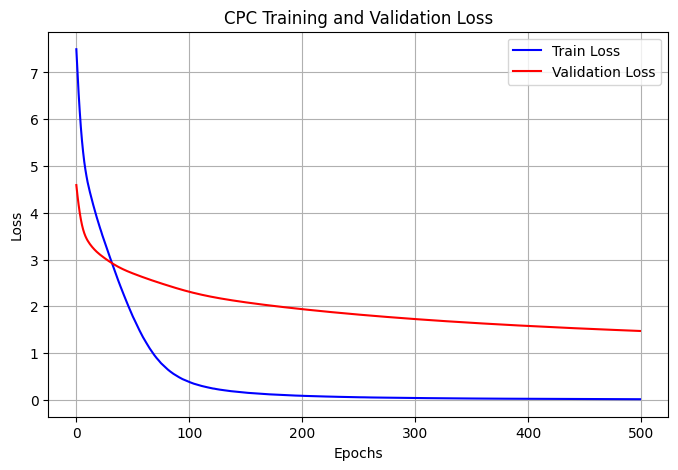

cpc_features_labeled shape: torch.Size([3356, 30, 128])
cpc_features_unlabeled shape: torch.Size([3365, 30, 128])
cpc_features_val shape: torch.Size([960, 30, 128])
cpc_features_test shape: torch.Size([1921, 30, 128])


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
class CPCModel(nn.Module):
    def __init__(self, input_dim, latent_dim, num_gru_layers, dropout_rate=0.1):
        super(CPCModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, latent_dim)
        )
        self.rnn = nn.GRU(
            input_size=latent_dim,
            hidden_size=128,
            num_layers=num_gru_layers,
            batch_first=True,
            bidirectional=False,
            dropout=dropout_rate
        )

    def forward(self, x):
        z = self.encoder(x)          # (batch_size, seq_len, latent_dim)
        context, _ = self.rnn(z)     # (batch_size, seq_len, hidden_size)
        return context              
def info_nce_loss(context, temperature=0.1):
    batch_size, seq_len, hidden_dim = context.shape
    similarities = torch.matmul(context, context.transpose(1, 2)) / temperature
    labels = torch.arange(seq_len, device=device).repeat(batch_size, 1)
    loss = nn.CrossEntropyLoss()(similarities.reshape(-1, seq_len), labels.reshape(-1))
    return loss
input_dim = x_labeled.shape[2]  
latent_dim = 128
num_gru_layers = 2
dropout_rate = 0.1
weight_decay = 1e-5
learning_rate = 1e-4
num_epochs = 500
cpc_model = CPCModel(input_dim, latent_dim, num_gru_layers, dropout_rate).to(device)
optimizer = optim.Adam(cpc_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    cpc_model.train()
    optimizer.zero_grad()
    context_labeled = cpc_model(x_labeled)
    context_unlabeled = cpc_model(x_unlabeled)
    loss_labeled = info_nce_loss(context_labeled, temperature=0.5)
    loss_unlabeled = info_nce_loss(context_unlabeled, temperature=0.5)
    total_loss = loss_labeled + loss_unlabeled
    total_loss.backward()
    optimizer.step()
    train_losses.append(total_loss.item())
    cpc_model.eval()
    with torch.no_grad():
        context_val = cpc_model(x_tensor_val)
        val_loss = info_nce_loss(context_val, temperature=0.5)
        val_losses.append(val_loss.item())
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('CPC Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
cpc_model.eval()
with torch.no_grad():
    cpc_features_labeled = cpc_model(x_labeled).clone().detach().to(device, dtype=torch.float32)
    cpc_features_unlabeled = cpc_model(x_unlabeled).clone().detach().to(device, dtype=torch.float32)
    cpc_features_val = cpc_model(x_tensor_val).clone().detach().to(device, dtype=torch.float32)
    cpc_features_test = cpc_model(x_tensor_test).clone().detach().to(device, dtype=torch.float32)
print(f'cpc_features_labeled shape: {cpc_features_labeled.shape}')
print(f'cpc_features_unlabeled shape: {cpc_features_unlabeled.shape}')
print(f'cpc_features_val shape: {cpc_features_val.shape}')
print(f'cpc_features_test shape: {cpc_features_test.shape}')


In [11]:

cpc_features_unlabeled = cpc_features_unlabeled.clone().detach().to(device)  
cpc_features_labeled = cpc_features_labeled.clone().detach().to(device)      
cpc_features_test = cpc_features_test.clone().detach().to(device)            
cpc_features_val = cpc_model(x_tensor_val)[0].clone().detach().to(device)    
y_tensor_labeled = y_labeled.clone().detach().to(device).long()
y_tensor_unlabeled = y_unlabeled.clone().detach().to(device).long()
y_tensor_test = y_tensor_test.clone().detach().to(device).long().squeeze()  
y_tensor_val = y_tensor_val.clone().detach().to(device).long()
print(f'cpc_features_unlabeled shape: {cpc_features_unlabeled.shape}')  # (num_unlabeled, seq_len, latent_dim)
print(f'cpc_features_labeled shape: {cpc_features_labeled.shape}')      # (num_labeled, seq_len, latent_dim)
print(f'cpc_features_test shape: {cpc_features_test.shape}')            # (num_test, seq_len, latent_dim)
print(f'cpc_features_val shape: {cpc_features_val.shape}')              # (num_val, seq_len, latent_dim)
print(f'y_tensor_labeled shape: {y_tensor_labeled.shape}')              # (num_labeled,)
print(f'y_tensor_unlabeled shape: {y_tensor_unlabeled.shape}')          # (num_unlabeled,)
print(f'y_tensor_test shape: {y_tensor_test.shape}')                    # (num_test,)
print(f'y_tensor_val shape: {y_tensor_val.shape}')                      # (num_val,)


cpc_features_unlabeled shape: torch.Size([3365, 30, 128])
cpc_features_labeled shape: torch.Size([3356, 30, 128])
cpc_features_test shape: torch.Size([1921, 30, 128])
cpc_features_val shape: torch.Size([30, 128])
y_tensor_labeled shape: torch.Size([3356])
y_tensor_unlabeled shape: torch.Size([3365])
y_tensor_test shape: torch.Size([1921])
y_tensor_val shape: torch.Size([960])


Embedding shape after pooling: (1921, 128)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


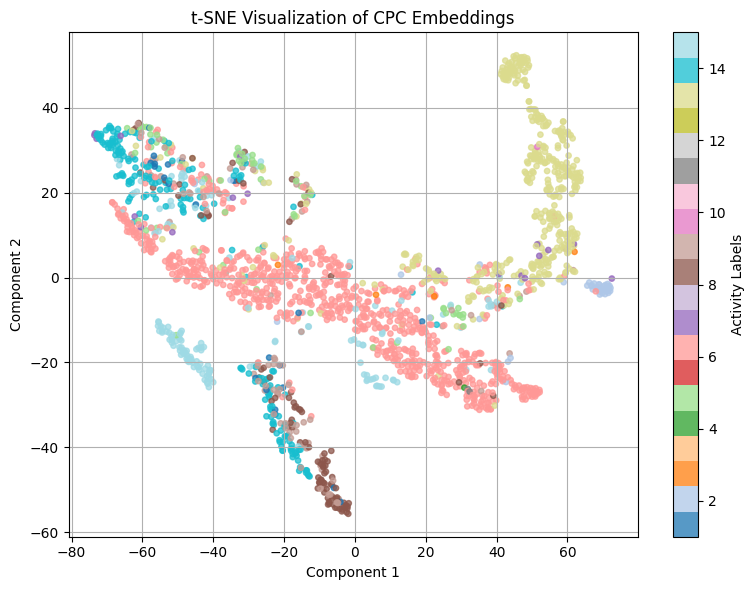

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

cpc_model.eval()

with torch.no_grad():
    # خروجی CPC: (batch, seq_len, hidden_dim)
    cpc_embeddings = cpc_model(x_tensor_test).cpu().numpy()

# ===== Mean Pooling روی بعد زمان =====
# (batch, seq_len, hidden) → (batch, hidden)
cpc_embeddings_mean = cpc_embeddings.mean(axis=1)

# لیبل‌های واقعی فقط برای visualization
true_labels = np.asarray(y_test)

print("Embedding shape after pooling:", cpc_embeddings_mean.shape)

# ===== t-SNE =====
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=2000,
    random_state=42
)

X_2d = tsne.fit_transform(cpc_embeddings_mean)

# ===== Plot =====
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=true_labels,
    cmap='tab20',
    s=15,
    alpha=0.75
)
plt.colorbar(scatter, label="Activity Labels")
plt.title("t-SNE Visualization of CPC Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


2025-12-23 07:02:52.390518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766473372.575210      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766473372.629988      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766473373.072874      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766473373.072933      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766473373.072936      55 computation_placer.cc:177] computation placer alr

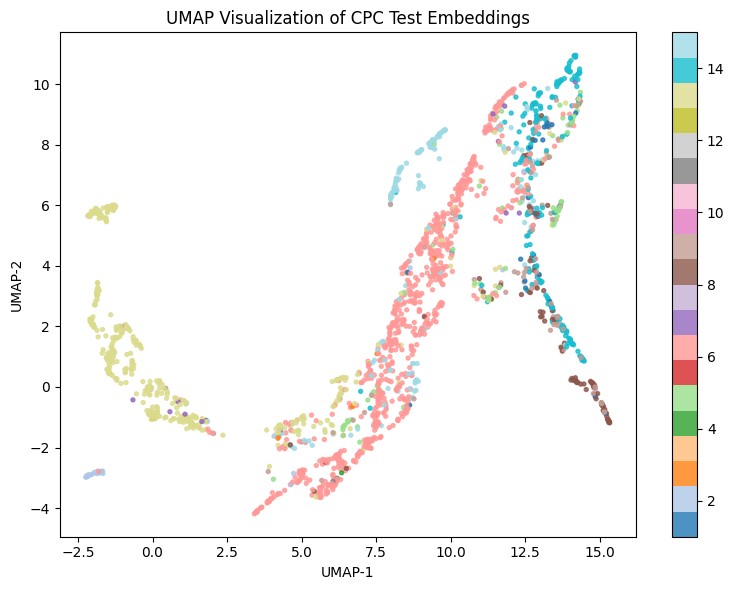

In [13]:
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Mean pooling روی embedding تست
cpc_embeddings_mean = cpc_features_test.mean(dim=1).cpu().numpy()

true_labels = y_test  # اگر numpy است، .cpu() نزن

reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='euclidean',
    random_state=42
)

X_umap = reducer.fit_transform(cpc_embeddings_mean)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_umap[:, 0],
    X_umap[:, 1],
    c=true_labels,
    cmap='tab20',
    s=8,
    alpha=0.8
)
plt.colorbar(scatter)
plt.title("UMAP Visualization of CPC Test Embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()


Using device: cuda
Epoch [50/500] - Train Loss: 1.6524, Val Loss: 1.5923
Epoch [100/500] - Train Loss: 1.3625, Val Loss: 1.3297
Epoch [150/500] - Train Loss: 1.2400, Val Loss: 1.2123
Epoch [200/500] - Train Loss: 1.1778, Val Loss: 1.1635
Epoch [250/500] - Train Loss: 1.1382, Val Loss: 1.1206
Epoch [300/500] - Train Loss: 1.0639, Val Loss: 1.0464
Epoch [350/500] - Train Loss: 1.0157, Val Loss: 0.9915
Epoch [400/500] - Train Loss: 0.9672, Val Loss: 0.9555
Epoch [450/500] - Train Loss: 0.9311, Val Loss: 0.9249
Epoch [500/500] - Train Loss: 0.9202, Val Loss: 0.9316
Train Metrics:
               precision    recall  f1-score   support

           0       0.80      0.98      0.88        94
           1       0.54      0.39      0.45        75
           2       0.72      0.83      0.77        87
           3       0.64      0.85      0.73        82
           4       0.71      0.92      0.80       104
           5       0.58      0.44      0.50        57
           6       0.79      0.85    

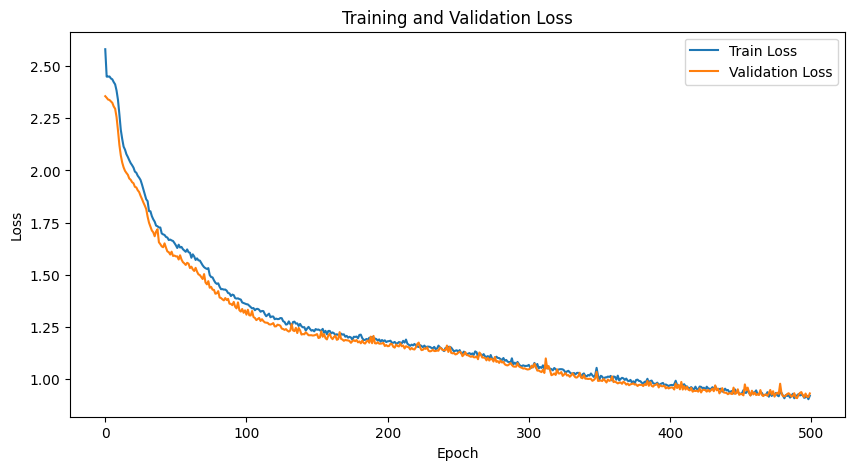

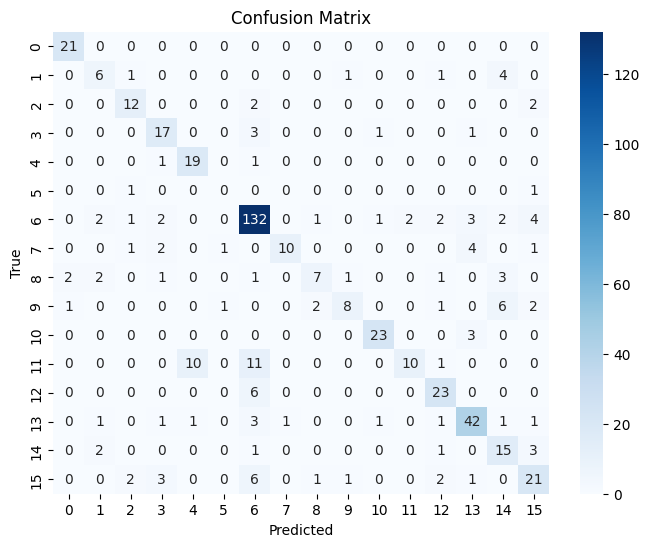

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]
class TransformerGRU(nn.Module):
    def __init__(self, input_dim, num_classes, unique_sensor_dim, d_model=128, num_heads=4, gru_hidden_sizes=[32,64,128], dropout=0.5):
        super().__init__()
        self.sensor_embedding = nn.Embedding(unique_sensor_dim, d_model)
        self.feature_embedding = nn.Linear(input_dim-1, d_model)
        self.pos_encoding = PositionalEncoding(d_model)
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, batch_first=True, dropout=dropout)
        self.gru1 = nn.GRU(d_model, gru_hidden_sizes[0], batch_first=True, bidirectional=True)
        self.gru2 = nn.GRU(gru_hidden_sizes[0]*2, gru_hidden_sizes[1], batch_first=True, bidirectional=True)
        self.gru3 = nn.GRU(gru_hidden_sizes[1]*2, gru_hidden_sizes[2], batch_first=True, bidirectional=True)
        self.fc = nn.Linear(d_model + gru_hidden_sizes[2]*2, num_classes)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        sensor_feat = x[:,:,0].long()
        other_feat = x[:,:,1:]
        sensor_emb = self.sensor_embedding(sensor_feat)
        other_emb = self.feature_embedding(other_feat)
        combined = sensor_emb + other_emb
        combined = self.pos_encoding(combined)
        attn_out,_ = self.attn(combined, combined, combined)
        attn_out = attn_out.mean(dim=1)
        gru_out,_ = self.gru1(combined)
        gru_out,_ = self.gru2(gru_out)
        gru_out,_ = self.gru3(gru_out)
        gru_out_last = torch.cat((gru_out[:, -1, :gru_out.shape[2]//2], gru_out[:,0, gru_out.shape[2]//2:]), dim=1)
        combined_out = torch.cat((attn_out, gru_out_last), dim=1)
        combined_out = self.dropout(combined_out)
        output = self.fc(combined_out)
        return output
def align_features_labels(features, labels):
    min_len = min(features.shape[0], labels.shape[0])
    return features[:min_len], labels[:min_len]
cpc_features_labeled, y_tensor_labeled = align_features_labels(cpc_features_labeled, y_tensor_labeled)
total_len = len(cpc_features_labeled)
train_len = int(0.7*total_len)
val_len = int(0.15*total_len)
test_len = total_len - train_len - val_len
dataset = TensorDataset(cpc_features_labeled, y_tensor_labeled)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_len, val_len, test_len])
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
input_dim = cpc_features_labeled.shape[2]
num_classes = len(torch.unique(y_tensor_labeled))
unique_sensor_dim = len(data['Sensor_Unique_Code'].unique())
model = TransformerGRU(input_dim, num_classes, unique_sensor_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-2)
num_epochs = 500
train_losses, val_losses = [], []
best_val_loss = np.inf
patience = 15
counter = 0
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    model.eval()
    val_loss_total = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            val_loss_total += val_loss.item()
    val_loss_avg = val_loss_total / len(val_loader)
    val_losses.append(val_loss_avg)
    if val_loss_avg < best_val_loss:
        best_val_loss = val_loss_avg
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    if (epoch+1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
def evaluate(loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            preds = torch.argmax(model(X), dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())
    return torch.cat(all_preds), torch.cat(all_labels)

model.load_state_dict(torch.load("best_model.pth"))

train_preds, train_labels = evaluate(train_loader)
val_preds, val_labels = evaluate(val_loader)
test_preds, test_labels = evaluate(test_loader)
print("Train Metrics:\n", classification_report(train_labels, train_preds))
print("Validation Metrics:\n", classification_report(val_labels, val_preds))
print("Test Metrics:\n", classification_report(test_labels, test_preds))
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
